[2.000e+00 3.000e+00 4.000e+00 ... 2.198e+03 2.199e+03 2.200e+03] [1207.8  1125.1  1048.6  ...  136.13  135.43  134.75]


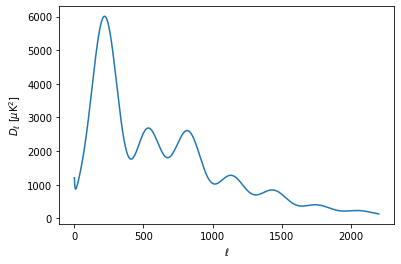

In [1]:
#整体分为三部分：1从camb.dat数据中生成L和CL的功率谱；2实现CMB天图；3从天图中调出功率谱与原功率谱对比
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import astropy.io.fits as fits

# First, to generate the power spectrum from camb.dat
ell, DlTT = np.loadtxt("camb_31137727_scalcls.dat", usecols=(0, 1), unpack=True)#仅读取0，1两列，分别为l,Cl
print(ell,DlTT)
plt.plot(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()



F:\anaconda\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log


map mean= -0.02516959861564259 map rms= 0.06877788099747421 max= 0.2897539399244007 min= -0.23800759000674765


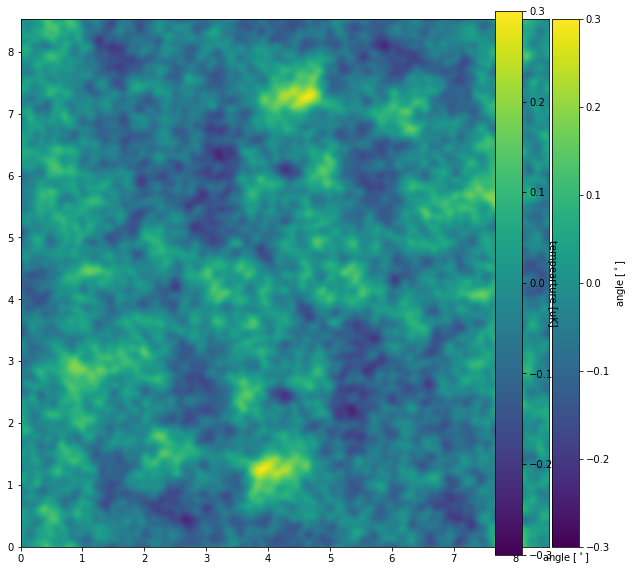

<Figure size 432x288 with 0 Axes>

In [20]:

# variables to set up the size of the map
N = 2**10  # this is the number of pixels in a linear dimension
            ## since we are using lots of FFTs this should be a factor of 2^N
pix_size  = 0.5 # size of a pixel in arcminutes

## variables to set up the map plots
c_min = -0.3  # minimum for color bar
c_max = 0.3 # maximum for color bar
X_width = N*pix_size/60.  # horizontal map width in degrees
Y_width = N*pix_size/60.  # vertical map width in degrees


def make_CMB_T_map(N,pix_size,ell,DlTT):
    "makes a realization of a simulated CMB sky map given an input DlTT as a function of ell," 
    "the pixel size (pix_size) required and the number N of pixels in the linear dimension."
    #np.random.seed(100)
    # convert Dl to Cl
    ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))
    ClTT[0] = 0. # set the monopole and the dipole of the Cl spectrum to zero
    ClTT[1] = 0.

    # make a 2D real space coordinate system
    onesvec = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.) # create an array of size N between -0.5 and +0.5
    # compute the outer product matrix: X[i, j] = onesvec[i] * inds[j] for i,j 
    # in range(N), which is just N rows copies of inds - for the x dimension
    X = np.outer(onesvec,inds) 
    # compute the transpose for the y dimension
    Y = np.transpose(X)
    # radial component R
    R = np.sqrt(X**2. + Y**2.)
    

    # now make a 2D CMB power spectrum
    pix_to_rad = (pix_size/60. * np.pi/180.) # 弧度转换 going from pix_size in arcmins to degrees and then degrees to radians
    ell_scale_factor = 2. * np.pi /pix_to_rad  # now relating the angular size in radians to multipoles   l的最大值
    ell2d = R * ell_scale_factor # making a fourier space analogue to the real space R vector 在K空间l对应的值
    ClTT_expanded = np.zeros(int(ell2d.max())+1)#置换为矩阵 
    # making an expanded Cl spectrum (of zeros) that goes all the way to the size of the 2D ell vector
    ClTT_expanded[0:(ClTT.size)] = ClTT # fill in the Cls until the max of the ClTT vector   l对应的CL的值
   
    # the 2D Cl spectrum is defined on the multiple vector set by the pixel scale
    CLTT2d = ClTT_expanded[ell2d.astype(int)] 
    plt.imshow(np.log(CLTT2d))#热图绘制
      
    
    # now make a realization of the CMB with the given power spectrum in real space
    random_array_for_T = np.random.normal(0,1,(N,N))
       # take FFT since we are in Fourier space 
    
    FT_2d = np.sqrt(CLTT2d) * random_array_for_T # we take the sqrt since the power spectrum is T^2
    plt.imshow(np.real(FT_2d))
    
    
    # move back from ell space to real space
    CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) 
    # move back to pixel space for the map
    CMB_T = CMB_T/(pix_size /60.* np.pi/180.)
    # we only want to plot the real component
    CMB_T = np.real(CMB_T)
    
    ## return the map
    return(CMB_T)


  #画图实现
def Plot_CMB_Map(Map_to_Plot,c_min,c_max,X_width,Y_width):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    #均值标准差
    print("map mean=",np.mean(Map_to_Plot),"map rms=",np.std(Map_to_Plot),"max=",np.max(Map_to_Plot),"min=",np.min(Map_to_Plot))
    plt.gcf().set_size_inches(10, 10)     #设置图的大小
    im = plt.imshow(Map_to_Plot, origin='lower')   
    im.set_clim(c_min,c_max)
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    cbar = plt.colorbar()
    im.set_extent([0,X_width,0,Y_width])
    plt.ylabel('angle $[^\circ]$')
    plt.xlabel('angle $[^\circ]$')
    cbar.set_label('tempearture [uK]', rotation=270)
    
    plt.show()
    
    return(0)

  ###############################

## make a CMB T map
CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)
Plot_CMB_Map(CMB_T,c_min,c_max,X_width,Y_width)
plt.clf()


 


F:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
F:\anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


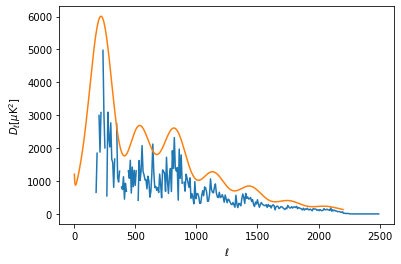

In [26]:
#第三步：产生CMB温度天图的功率谱,并对比
#parameters for setting up the spectrum
delta_ell=8
ell_max=2500

 
def calculate_2d_spectrum(Map1,Map2,delta_ell,ell_max,pix_size,N):
	#make a 2d ell coordinate system
	ones=np.ones(N)#与上面一样
	inds=(np.arange(N)+.5-N/2.)/(N-1.)
	kX=np.outer(ones,inds)
	kY=np.transpose(kX)
	K=np.sqrt(kX**2.+kY**2.)
	pix_to_rad=(pix_size/60.*np.pi/180.)
	ell_scale_factor=2.*np.pi /pix_to_rad   #l的最大值
	ell2d=K*ell_scale_factor       #在K空间l的值
	
	#make an array to hold the power spectrum results
	N_bins=int(ell_max/delta_ell)
	ell_array=np.arange(N_bins)
	CL_array=np.zeros(N_bins)
	
	#get the 2d Fourier transform of the map
	FMap1=np.fft.ifft2(np.fft.fftshift(Map1))
	FMap2=np.fft.ifft2(np.fft.fftshift(Map2))
	
	a=np.conj(FMap1)*FMap2
	PSMap=np.fft.fftshift(np.real(a))     # T_k*T_k
	
	#fill out the spectra
	i=0
	while(i<N_bins):
		ell_array[i]=(i+0.5)*delta_ell
		inds_in_bin=((ell2d>=(i*delta_ell))*(ell2d<(i+1)*delta_ell)).nonzero()   #ell2d在该范围的索引值
		CL_array[i]=np.mean(PSMap[inds_in_bin])
		#print i, ell, ell_array[i], inds_in_bin, CL_array[i]
		i=i+1
	
	#return the power spectrum and ell bins
	return(ell_array,CL_array*np.sqrt(pix_size/60.*np.pi/180.)*2.)




## make a power spectrum
binned_ell, binned_spectrum=calculate_2d_spectrum(CMB_T,CMB_T,delta_ell,ell_max,pix_size,N)#值分别来自于2d-spectrum
plt.plot(binned_ell,binned_spectrum*binned_ell*(binned_ell+1.)/2./np.pi*10**6)   
plt.plot(ell,DlTT)#两个对比
plt.ylabel('$D_{\ell}$[$\mu$K$^2$]')
plt.xlabel('$\ell$')

plt.show()
